### On CBT measurement 
*3.4.2014 Leif Roschier/Aivon Oy*

>**Note: this document is written with [ipython notebook](http://ipython.org/notebook.html) . You can install ipython, download this document and run it with your own computer.**

This document discusses some capabilities of typical CBT sensor.

Here we setup the environment for the document and load pyCBT libraries.



In [38]:
from matplotlib import pyplot as plt
import sys, time
sys.path.append( '../src' ) # path where source is
from CBT_lib import calc_G
import numpy as np

sys.path.append( '../../../Max_Code')
from CBT_Array import CBT_Array, high_resistance_G0_first_order, high_resistance_G0_to_T_first_order, high_resistance_G0_third_order, high_resistance_G0_to_T_third_order, kB, e
%matplotlib widget

A good way to use Coulomb blockade thermometer (CBT) is to calibrate it by measuring curves at few low temperatures. For example 15 mK, 20 mK, 30 mK and 40 mK. Too low temperatures are not good for calibration because unknown external (noise heating the island) affects the curve. So safe value for lowest temperature is around 15 mK to 20 mK just to be sure (even when the sensor works well in low noise environment way below 10 mK.) Too high temperatures are also bad because dip in GV-curves gets shallow and relative noise large. One should do all measurements with same lockin-amplifier settings. Otherwise small changes in resistance reading  ruin the temperature measurements at higher temperatures where $dR/dT$ is small. 

If range below 10 mK is of interest, lockin excitation around 5 $\mu$V is recommended ($V_{ac}<< k_B T/(Ne)$, where $N$ is number of junctions in series)

Calibration can be done using multifit from pyCBT library. In the end two constants characterize the sensor: $R_T$ the tunnelling resistance and $C_{\Sigma}$ the island capacitance. CBT is a primary thermometer. By measuring conductance curves one calibrates the sensor.


In the following we use values for $R_T$ and $C_{\Sigma}$ taken from multifit of real measurements. The goal is to calculate numbers related to secondary mode measurement, where resistance is measured at zero-bias and temperature is converted from the resistance. At first we calculate $R$ vs. $T$

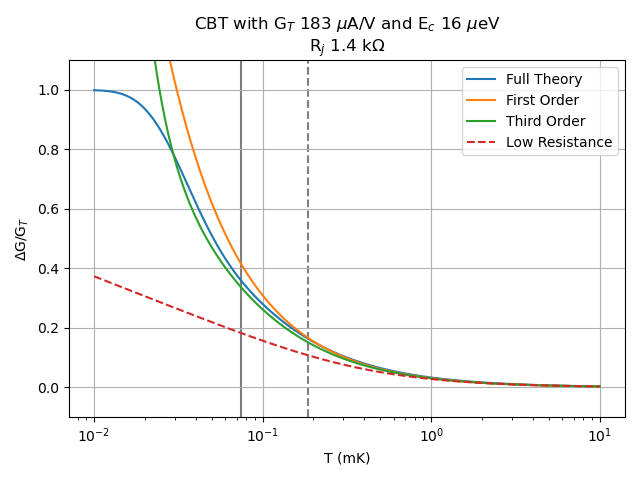

In [54]:
parallel_arrays = 3  # arrays parallel    
N_junctions=12        # junctions in each array
excitation = 5e-6/N_junctions  # excitation of measurement
island_size_init= (2.6E-6*0.1E-6*250E-10)*1E15#x 1e-15 m3, island size for heating calculations
Ec = 16 # ueV
Gt = 183 # uA/V


R_T = (1/(Gt * 1E-6)) * (parallel_arrays/N_junctions) # tunnelling resistance
C_sigma = ((((N_junctions-1)/N_junctions) * e**2 )/(Ec * e * 1E-6)) # C_sigma

sigma = 0.2e9 # electron-phonon couling constant
N = 2 # junctions in calculation
const_P = 100e-18
temps = np.logspace(-2, 1, 500) # make vector of temperatures

# function to calculate resistance as a function of temperature with above parameters
def G_func(temp):
    v_meas = 1e-9 # bias voltage, made small but non-zero.
    g = calc_G(sigma,N,v_meas,R_T,C_sigma,temp ,island_size_init, const_P, excitation)*parallel_arrays/N_junctions*N
    return g * 1E6




G1=[]
for t in temps:
    G1.append(G_func(t))

G1 = np.array(G1)
dGoGT = (Gt - G1)/Gt

Gfo = high_resistance_G0_first_order(temps, Gt, Ec)
dGoGTfo = (Gt - Gfo)/Gt
Tfo = high_resistance_G0_to_T_first_order(G1, Gt, Ec)
dToTfo = (Tfo - temps)/temps

Gto = high_resistance_G0_third_order(temps, Gt, Ec)
dGoGTto = (Gt - Gto)/Gt
Tto = high_resistance_G0_to_T_third_order(G1, Gt, Ec)
dToTto = (Tto - temps)/temps

CBT = CBT_Array(Gt, Ec)
Glr = CBT.G0(temps)
dGoGTlr = (Gt - Glr)/Gt


# plot results
fig, ax = plt.subplots(1, sharex=True)
ax.semilogx(temps, dGoGT, label="Full Theory")
ax.semilogx(temps, dGoGTfo, label="First Order")
ax.semilogx(temps, dGoGTto, label="Third Order")
ax.semilogx(temps, dGoGTlr, "--", label="Low Resistance")
ax.set_xlabel("T (mK)")
ax.set_ylabel("$\Delta$G/G$_T$")
ax.legend()
ax.set_title(f"CBT with G$_T$ {Gt} $\mu$A/V and E$_c$ {Ec} $\mu$eV\nR$_j$ {R_T*1E-3:.1f} k$\Omega$")
ax.set_ylim([-0.1, 1.1])
ax.axvline((Ec*e*1E-6)/kB, c="k", ls="--", zorder=-100, alpha=0.5)
ax.axvline(0.4 * (Ec*e*1E-6)/kB, c="k", zorder=-100, alpha=0.5)
ax.grid()


# ax1.semilogx(temps, temps*0)
# ax1.semilogx(temps, dToTfo, label="First Order")
# ax1.semilogx(temps, dToTto, label="Third Order")
# ax.set_xlabel("T (mK)")
# ax.set_ylabel("$\Delta$T/T")

# ax1.axvline((Ec*e*1E-6)/kB, c="k", ls="--", zorder=-100, alpha=0.5)
# ax1.axvline(0.4 * (Ec*e*1E-6)/kB, c="k", zorder=-100, alpha=0.5)
# ax1.set_ylim([-0.1, 0.1])

fig.tight_layout()

Next we calculate $dT/dR$. In log-log plot this is a straight line due to the exponential nature of the tunnelling process w.r.t temperature.

In [52]:
ax.set_ylim([-0.1, 1.1])

(-0.1, 1.1)

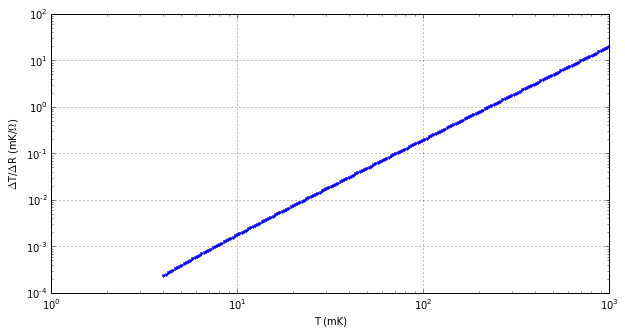

In [16]:
dt_dR = []
for t in temps:
    dt_dR.append(1.0/(R_func(t+5e-4)-R_func(t-5e-4)))
loglog(array(temps)*1000, -array(dt_dR),'.')
xlabel("T (mK)"),ylabel("$\Delta$T/$\Delta$R (mK/$\Omega$)")
grid()    


Next we calcuate temperature measurement error $\Delta T$ vs. voltage-noise over measurement period (for example 1 second) assuming 5 $\mu$V excitation. $\Delta T = (\Delta T/\Delta R) \times \Delta R = (\Delta T/\Delta R)\times R\times \delta V/V_{AC}$

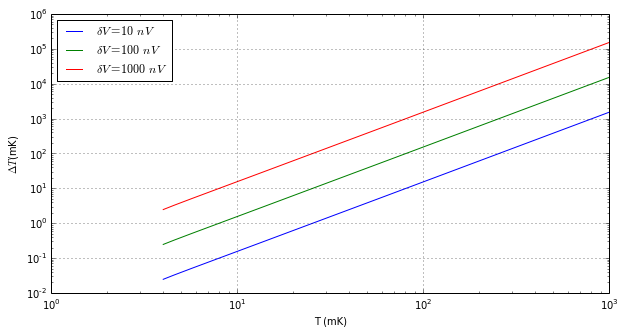

In [18]:
V_ac = 5e-6 # assumed AC excitation
dV = [10e-9, 100e-9, 1000e-9] # voltage noise levels
dT0 = []
dT1 = []
dT2 = []
for idx,t in enumerate(temps):
    dT0.append(dt_dR[idx]*R1[idx]*dV[0]/V_ac)
    dT1.append(dt_dR[idx]*R1[idx]*dV[1]/V_ac)
    dT2.append(dt_dR[idx]*R1[idx]*dV[2]/V_ac)
loglog(array(temps)*1000, -array(dT0),'-',label="$ \delta V = 10\,nV$")
loglog(array(temps)*1000, -array(dT1),'-',label="$ \delta V = 100\,nV$")
loglog(array(temps)*1000, -array(dT2),'-',label="$ \delta V = 1000\,nV$")
xlabel("T (mK)"),ylabel("$\Delta T$(mK)")
legend(loc=2)
grid() 

Relative temperature errors can be calculated from previous analysis.

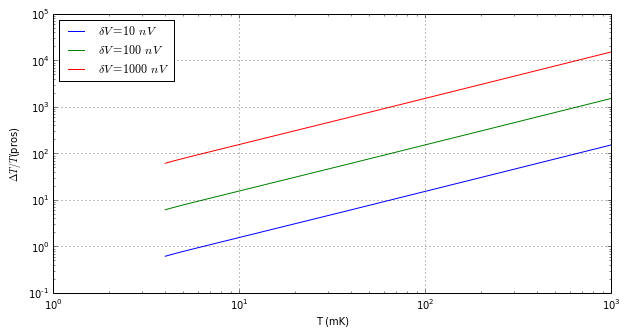

In [19]:
V_ac = 5e-6 # assumed AC excitation
dV = [10e-9, 100e-9, 1000e-9] # voltage noise levels
drT0 = []
drT1 = []
drT2 = []
for idx,t in enumerate(temps):
    drT0.append(1e-3*dT0[idx]/t)
    drT1.append(1e-3*dT1[idx]/t)
    drT2.append(1e-3*dT2[idx]/t)
loglog(array(temps)*1000, -array(drT0)*100,'-',label="$ \delta V = 10\,nV$")
loglog(array(temps)*1000, -array(drT1)*100,'-',label="$ \delta V = 100\,nV$")
loglog(array(temps)*1000, -array(drT2)*100,'-',label="$ \delta V = 1000\,nV$")
xlabel("T (mK)"),ylabel("$\Delta T/T$(pros)")
legend(loc=2)
grid() 


It is obvious that one needs good low-noise preamplifier for the measurement. Measuring temperatures above 100 mK get challenging due to the noise level. Higher excitation level helps, but one has to be sure resistance measurement stays accurate and consistent to calibration.